In [1]:
import dedalus_sphere.zernike as Zernike
import dedalus_sphere.jacobi as Jacobi

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=3,suppress=True)

dim = 2
D = Zernike.operator(dim, 'D')
E = Zernike.operator(dim, 'E')
R = Zernike.operator(dim, 'R')
Id = Zernike.operator(dim,'Id')


import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import stretched_sphere
RdR = stretched_sphere.zernike_operator(dim, 'RdR')



In [2]:
# Conversion operators
n, k, m = 6, 0, 2
r = np.linspace(0,1,2000)[1:]
z = 2*r**2 - 1
Tn = Zernike.polynomials(dim,n,k,  m,z).T
Un = Zernike.polynomials(dim,n,k+1,m,z).T

# Convert basis polynomials Un to Tn
assert np.max(abs(Tn - Un @ E(+1)(n,k,m))) < 1e-14

# Apply conversion to coefficients of expansion
cT = ((n-np.arange(n))/n)**2
cU = E(+1)(n,k,m) @ cT
fT = Tn @ cT
fU = Un @ cU
assert np.max(abs(fT - fU)) < 1e-14


In [3]:
# Test R and Z multiplication
n, k, m = 6, 0, 4
r = np.linspace(0,1,2000)[1:]
z = 2*r**2 - 1
Tn = Zernike.polynomials(dim,n+1,k,m,z).T
Up = Zernike.polynomials(dim,n,k,m+1,z).T
Um = Zernike.polynomials(dim,n+1,k,m-1,z).T

c = ((n-np.arange(n))/n)**2
f = Tn[:,:-1] @ c

# R multiplication
rf = r*f
rfp = Up @ R(+1)(n,k,m) @ c
rfm = Um @ R(-1)(n,k,m) @ c
errorp = rf - rfp
errorm = rf - rfm
assert np.max(abs(errorp)) < 1.25e-14
assert np.max(abs(errorm)) < 1e-14

# Multiply by R**2 - requires n+1 polynomials
r2f = r**2*f
r2fcoeff = Tn @ (R(-1) @ R(+1))(n,k,m) @ c
error = r2fcoeff - r2f
assert np.max(abs(error)) < 1e-14

# Z = 2*R**2 - 1 multiplication requires n+1 polynomials
zf = z*f
# zfcoeff = Tn @ (2*(R(-1) @ R(+1)) - Id)(n,k,m) @ c 
zfcoeff = Tn @ Zernike.operator(dim,'Z')(n,k,m) @ c 
error = zf - zfcoeff
assert np.max(abs(error)) < 1e-14


In [4]:
# Test D+ and D- operators
n, k, m = 6, 0, 3
r = np.linspace(0,1,2000)[1:]
z = 2*r**2 - 1
Tn = Zernike.polynomials(dim,n,k,m,z).T
Up = Zernike.polynomials(dim,n-1,k+1,m+1,z).T
Um = Zernike.polynomials(dim,n,k+1,m-1,z).T

c = ((n-np.arange(n))/n)**2
f = Tn @ c

# D+ and D- operators
cp = D(+1)(n,k,m) @ c
cm = D(-1)(n,k,m) @ c
fp = Up @ cp
fm = Um @ cm
fpapprox = (f[2:]-f[:-2])/(r[2:]-r[:-2]) - (m/r*f)[1:-1]
fmapprox = (f[2:]-f[:-2])/(r[2:]-r[:-2]) + (m/r*f)[1:-1]
errorp = fp[1:-1] - fpapprox
errorm = fm[1:-1] - fmapprox
assert np.max(abs(errorp)) < 3e-3
assert np.max(abs(errorm)) < 3e-3


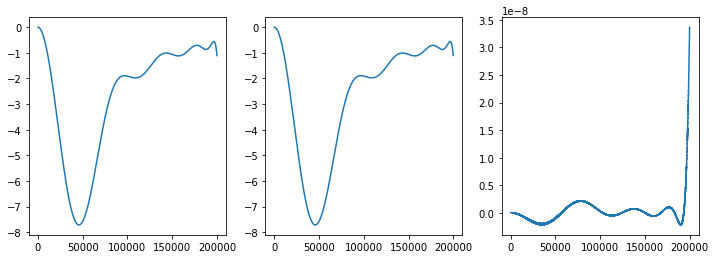

In [5]:
# Test r*d/dr
n, k, m = 6, 0, 3
r = np.linspace(0,1,200000)[1:]
z = 2*r**2 - 1
Tn = Zernike.polynomials(dim,n,k,m,z).T
Un = Zernike.polynomials(dim,n,k+1,m,z).T

c = ((n-np.arange(n))/n)**2 * (-1)**np.arange(n)
f = Tn @ c

op = RdR(n,k,m)

fp = Un @ op @ c
fpapprox = r[1:-1]*(f[2:]-f[:-2])/(r[2:]-r[:-2])
error = fp[1:-1] - fpapprox
assert np.max(abs(error)) < 2e-8


# Test r*d/dr, m = 0
n, k, m = 10, 0, 0
r = np.linspace(0,1,200000)[1:]
z = 2*r**2 - 1
Tn = Zernike.polynomials(dim,n,k,m,z).T
Un = Zernike.polynomials(dim,n,k+1,m,z).T

c = ((n-np.arange(n))/n)**2 * (-1)**np.arange(n)
f = Tn @ c

op = RdR(n,k,m)

fp = Un @ op @ c
fpapprox = r[1:-1]*(f[2:]-f[:-2])/(r[2:]-r[:-2])
error = fp[1:-1] - fpapprox
assert np.max(abs(error)) < 3.4e-8

fig, plot_axes = plt.subplots(1,3,figsize=(12,4))
plot_axes[0].plot(fp)
plot_axes[1].plot(fpapprox)
plot_axes[2].plot(error)


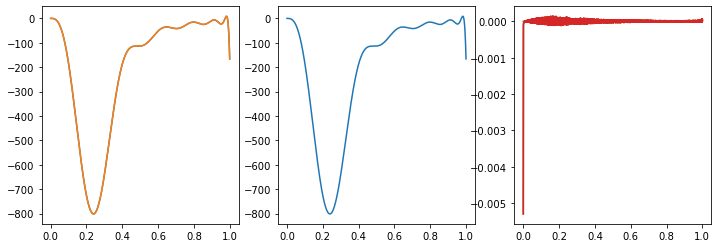

In [17]:
# Test laplacian
n, k, m = 12, 0, 3
r = np.linspace(0,1,200000)[1:]
z = 2*r**2 - 1
Tn = Zernike.polynomials(dim,n,k,m,z).T
Un = Zernike.polynomials(dim,n-1,k+2,m,z).T

c = ((n-np.arange(n))/n)**2 * (-1)**np.arange(n)
f = Tn @ c
fp1 = Un @ (D(-1) @ D(+1))(n,k,m) @ c
fp2 = Un @ (D(+1) @ D(-1))(n,k,m) @ c
h = r[1]-r[0]
dr = lambda g: (g[2:]-g[:-2])/(2*h)
fpapprox = 1/r[2:-2]*dr(r[1:-1]*dr(f)) - (m**2/r**2 * f)[2:-2]

error1 = fp1[2:-2] - fpapprox
error2 = fp2[2:-2] - fpapprox
assert np.max(abs(error1)) < .006        # r=0 causes a lot of error in FD approximation
assert np.max(abs(error1[130:])) < 2e-4  # Remove near r=0 and tighten tolerance
assert np.max(abs(error2)) < .006        # r=0 causes a lot of error in FD approximation
assert np.max(abs(error2[130:])) < 2e-4  # Remove near r=0 and tighten tolerance
assert np.max(abs(fp1-fp2)) < 1e-11

fig, plot_axes = plt.subplots(1,3,figsize=(12,4))
plot_axes[0].plot(r,fp1)
plot_axes[0].plot(r,fp2)
plot_axes[1].plot(r[2:-2],fpapprox)
plot_axes[2].plot(r[2:-2],error1)
plot_axes[2].plot(r[2:-2],error2)
plot_axes[2].plot(r,fp1-fp2)
plot_axes[2].plot(r[2:-2],error1)



In [7]:
# A bunch of R multiplication operators
n, k, m = 12, 0, 4
r = np.linspace(0,1,2000)[1:]
z = 2*r**2 - 1

c = ((n-np.arange(n))/n)**2
Pn = Zernike.polynomials(dim,n,k,m,z).T
f = Pn @ c

H = Id - R(-1) @ R(+1)

# R
fgrid = r*f
opp = R(+1)
opm = R(-1)

Pn = Zernike.polynomials(dim,n,k,m+1,z).T
fcoeff = Pn @ opp(n,k,m) @ c
error = fgrid - fcoeff
assert np.max(abs(error)) < 5e-14

Pn = Zernike.polynomials(dim,n+1,k,m-1,z).T
fcoeff = Pn @ opm(n,k,m) @ c
error = fgrid - fcoeff
assert np.max(abs(error)) < 5e-14


# (1-R**2)
fgrid = (1-r**2)*f
op = H

Pn = Zernike.polynomials(dim,n+1,k,m,z).T
fcoeff = Pn @ op(n,k,m) @ c
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-15


# (1-R**2)**2
fgrid = (1-r**2)**2*f
op = H @ H

Pn = Zernike.polynomials(dim,n+2,k,m,z).T
fcoeff = Pn @ op(n,k,m) @ c
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-15


# (1-R**2)**3
fgrid = (1-r**2)**3*f
op = H @ H @ H

Pn = Zernike.polynomials(dim,n+3,k,m,z).T
fcoeff = Pn @ op(n,k,m) @ c
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-15


# R * (1-R**2)**2
fgrid = r*(1-r**2)**2*f
opp = R(+1) @ H @ H
opm = R(-1) @ H @ H

Pn = Zernike.polynomials(dim,n+2,k,m+1,z).T
fcoeff = Pn @ opp(n,k,m) @ c
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-15

Pn = Zernike.polynomials(dim,n+3,k,m-1,z).T
fcoeff = Pn @ opm(n,k,m) @ c
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-15


# R**2 * (1-R**2)**2
fgrid = r**2*(1-r**2)**2*f
op = R(-1) @ R(+1) @ H @ H

Pn = Zernike.polynomials(dim,n+3,k,m,z).T
fcoeff = Pn @ op(n,k,m) @ c
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-15


# R**3 * (1-R**2)**2
fgrid = r**3*(1-r**2)**2*f
opp = R(+1) @ R(-1) @ R(+1) @ H @ H
opm = R(-1) @ R(-1) @ R(+1) @ H @ H

Pn = Zernike.polynomials(dim,n+3,k,m+1,z).T
fcoeff = Pn @ opp(n,k,m) @ c
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-15

Pn = Zernike.polynomials(dim,n+4,k,m-1,z).T
fcoeff = Pn @ opm(n,k,m) @ c
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-15


In [8]:
# A bunch of d/dR operators
n, k, m = 12, 0, 4
r = np.linspace(0,1,400000)[1:]
z = 2*r**2 - 1

c = ((n-np.arange(n))/n)**2
Pn = Zernike.polynomials(dim,n,k,m,z).T
f = Pn @ c

H = Id - R(-1) @ R(+1)

# R*d/dR
fgrid = r[1:-1]*(f[2:]-f[:-2])/(r[2:]-r[:-2])
op = RdR

Pn = Zernike.polynomials(dim,n,k+1,m,z).T
fcoeff = Pn @ op(n,k,m) @ c
fcoeff = fcoeff[1:-1]
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-5


# R**2*d/dR
fgrid = r[1:-1]**2*(f[2:]-f[:-2])/(r[2:]-r[:-2])
op = R(+1) @ RdR

Pn = Zernike.polynomials(dim,n,k+1,m+1,z).T
fcoeff = Pn @ op(n,k,m) @ c
fcoeff = fcoeff[1:-1]
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-5


# (1-R**2)*R*d/dR
fgrid = (1-r[1:-1]**2)*r[1:-1]*(f[2:]-f[:-2])/(r[2:]-r[:-2])
op = H @ RdR

Pn = Zernike.polynomials(dim,n+1,k+1,m,z).T
fcoeff = Pn @ op(n,k,m) @ c
fcoeff = fcoeff[1:-1]
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-7


# R*(1-R**2)*R*d/dR
fgrid = (r*(1-r**2)*r)[1:-1]*(f[2:]-f[:-2])/(r[2:]-r[:-2])
opp = R(+1) @ H @ RdR
opm = R(-1) @ H @ RdR

Pn = Zernike.polynomials(dim,n+1,k+1,m+1,z).T
fcoeff = Pn @ opp(n,k,m) @ c
fcoeff = fcoeff[1:-1]
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-7

Pn = Zernike.polynomials(dim,n+2,k+1,m-1,z).T
fcoeff = Pn @ opm(n,k,m) @ c
fcoeff = fcoeff[1:-1]
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-7


In [9]:
# Adjoint of conversion operator is equivalent to a lowering (1-r**2) multiplication
n, k, m = 12, 2, 4
r = np.linspace(0,1,2000)[1:]
z = 2*r**2 - 1

c = ((n-np.arange(n))/n)**2
Pn = Zernike.polynomials(dim,n,k,m,z).T
f = Pn @ c

# (1-r**2)*f
fgrid = (1-r**2)*f
op = E(-1)

Pn = Zernike.polynomials(dim,n+1,k-1,m,z).T
fcoeff = Pn @ op(n,k,m) @ c
error = fgrid - fcoeff
assert np.max(abs(error)) < 1e-14


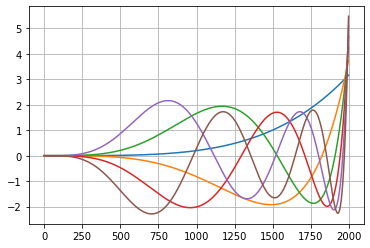

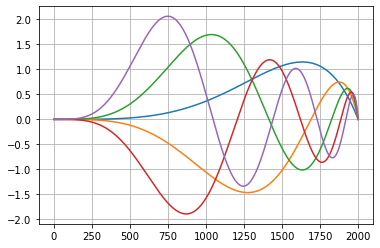

In [10]:
# Construct a Dirichlet basis for Zernike polynomials
Nmax, k, m = 6, 0, 4
r = np.linspace(0,1,2000)[1:]
z = 2*r**2 - 1

op = E(-1)
Pn = Zernike.polynomials(dim,Nmax,k,m,z).T
Qn = Pn @ op(Nmax-1,k+1,m)

assert np.max(abs(Qn[-1,:])) < 1e-15

plt.figure()
plt.plot(Pn)
plt.grid()

plt.figure()
plt.plot(Qn)
plt.grid()


In [11]:
# Construct a Dirichlet basis for Zernike polynomials
Nmax, k, m = 6, 1, 4
r = np.linspace(0,1,2000)[1:]
z = 2*r**2 - 1

# Conversion operator E+
Pn = Zernike.polynomials(dim,Nmax,k-1,m,z).T
Qn = Zernike.polynomials(dim,Nmax,k,m,z).T
Qn = Qn @ E(+1)(Nmax,k-1,m) 
assert np.max(abs(Pn-Qn)) < 8e-14

# Conversion operator E- is equivalent to multiplication by 1-r**2
rr = np.reshape(r,(len(r),1))
Pn = (1-rr**2) * Zernike.polynomials(dim,Nmax,k,m,z).T
Qn = Zernike.polynomials(dim,Nmax+1,k-1,m,z).T
Qn = (Qn @ E(-1)(Nmax,k,m))[:,:Nmax]
assert np.max(abs(Pn-Qn)) < 8e-15

# Act on coefficients
c = np.ones(Nmax)
c[-1] = 0   # Throw away the highest mode else we get errors from E(-1)
fgrid = (1-r**2) * (Zernike.polynomials(dim,Nmax,k,m,z).T @ c)
fcoeff = Zernike.polynomials(dim,Nmax,k-1,m,z).T @ (E(-1)(Nmax,k,m) @ c)[:Nmax]
assert np.max(abs(fgrid-fcoeff)) < 1e-14

# E(+) @ E(-) F == (1-r**2) f
Qn = Zernike.polynomials(dim,Nmax+1,k,m,z).T
Qn = (Qn @ (E(+1) @ E(-1))(Nmax,k,m))[:,:Nmax]
assert np.max(abs(Pn-Qn)) < 8e-15

# E(-) @ E(+) F == (1-r**2) f
Qn = Zernike.polynomials(dim,Nmax+1,k,m,z).T
Qn = (Qn @ (E(-1) @ E(+1))(Nmax,k,m))[:,:Nmax]
assert np.max(abs(Pn-Qn)) < 8e-15

# Multiply by Id - R(-) @ R(+) - tridiagonal
Pn = (1-rr**2) * Zernike.polynomials(dim,Nmax,k,m,z).T
Qn = Zernike.polynomials(dim,Nmax+1,k,m,z).T
Qn = (Qn @ (Id - R(-1) @ R(+1))(Nmax,k,m))[:,:Nmax]
assert np.max(abs(Pn-Qn)) < 5e-14


In [12]:
print('Success!')

Success!


In [13]:
print((R(-1) @ R(+1))(4,1,3).todense())
print((R(+1) @ R(-1))(4,1,3).todense())

[[0.667 0.178 0.    0.   ]
 [0.178 0.583 0.211 0.   ]
 [0.    0.211 0.55  0.226]
 [0.    0.    0.226 0.533]
 [0.    0.    0.    0.233]]
[[0.667 0.178 0.    0.   ]
 [0.178 0.583 0.211 0.   ]
 [0.    0.211 0.55  0.226]
 [0.    0.    0.226 0.533]
 [0.    0.    0.    0.233]]
